In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from NewsSentiment import TargetSentimentClassifier
from scipy.signal import savgol_filter


# Equiring the Data

## 1. News API

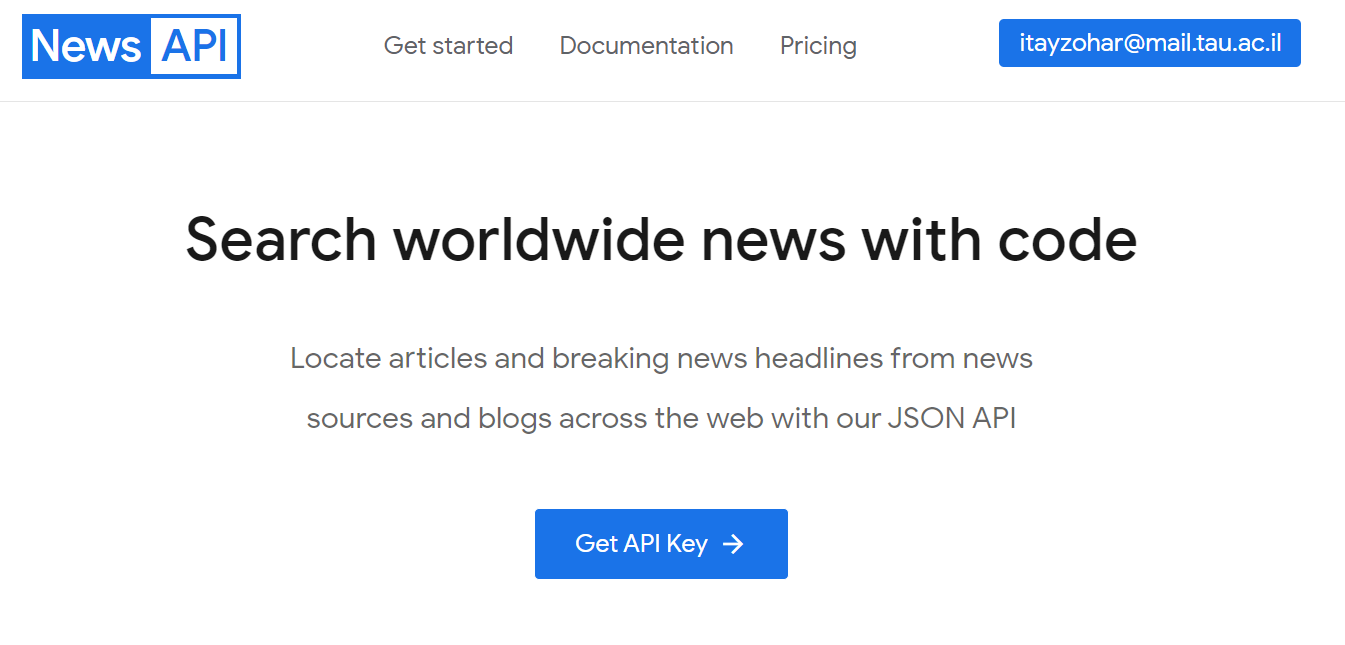


### only one month of data for the free:
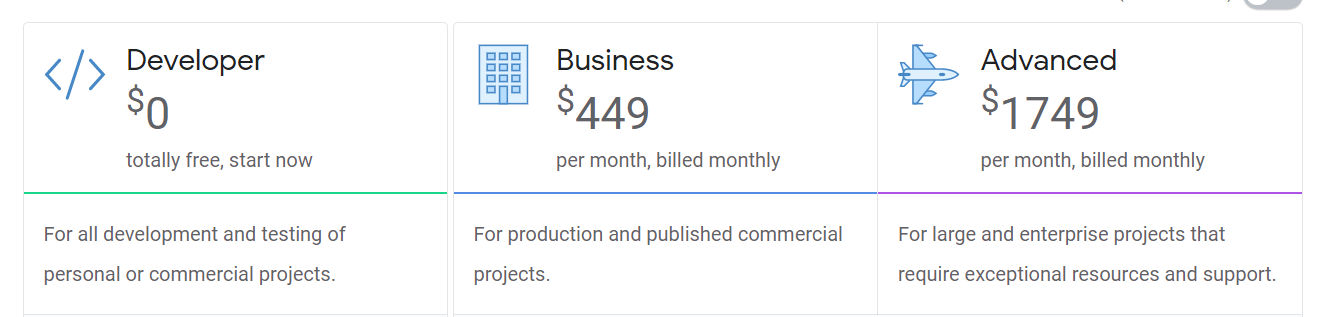

### might be too slow
**request requires pagination:**  
  
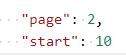

  
**and then requires scraping for every article indepenetly**
  
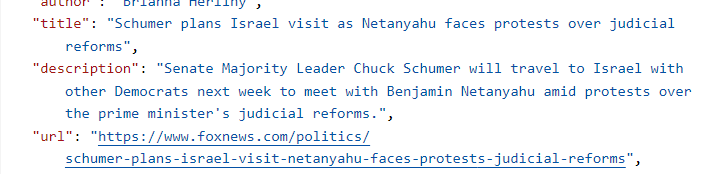

## 2. Implement ourself

## meet our `Scraper`

**class for for every source we need:**
  
 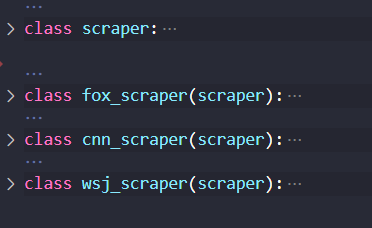

**that uses the source internal API:**  
  
 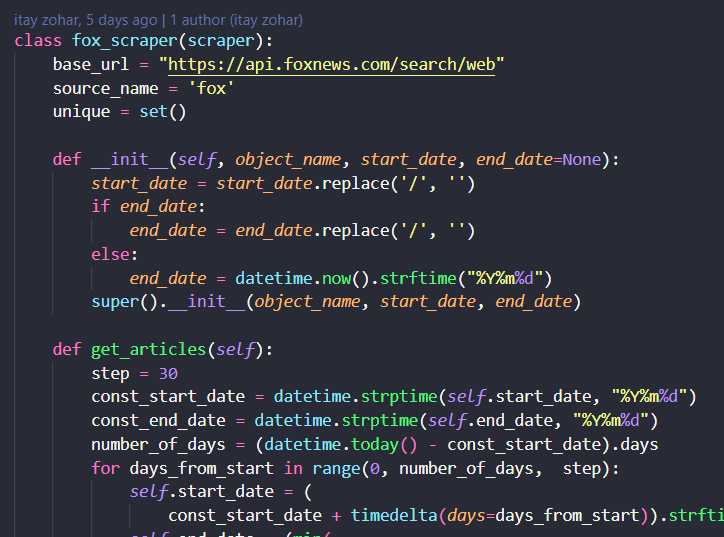

## scraping at scale: `CNN`
  
  **cnn returns the entire content of every article in history! (actually, about 3 years of data)**  
  
  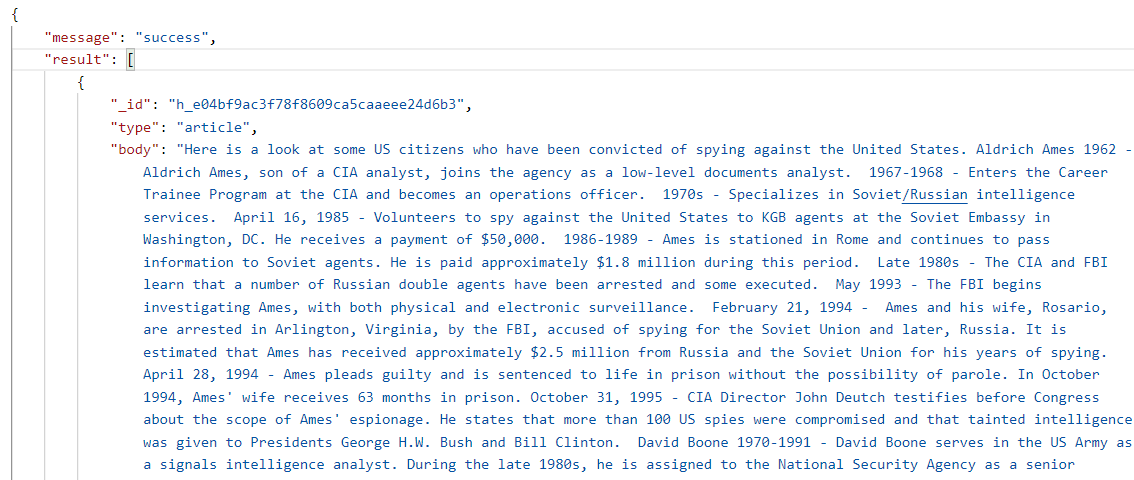

  
 **articles about netanyhu**:  
   
 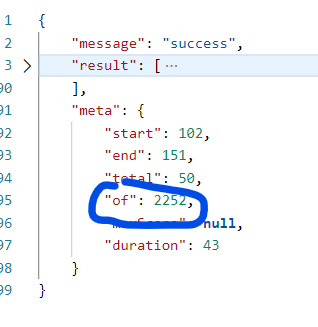
  
  
    
 **saved to csv in 20 secnods**
 
![SegmentLocal](scrape.gif "segment")

## Handling with bugs: `FOX`

**if page number is larger then 100, it explodes ! what can we do?**  
  
*query one month at a time and hope there's less then 100 articles in a signle month*  
*which wasn't fun*  
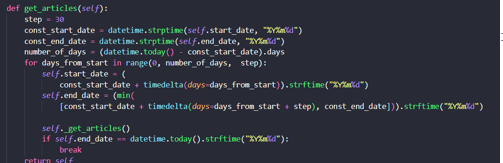

# Handling Data

## Option 1: Vader NLTK model

"The VADER sentiment lexicon is sensitive both the polarity and the intensity of sentiments expressed in social media contexts, and is also generally applicable to sentiment analysis in other domains."<br><br>
Returns distribution (not probability!!) of neg, pos, neu words, and compound score- which is the sentiment the model sees.
## Example:

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.-------------- {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.-------------- {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!------------ {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!! {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.--------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
At least it isn't a horrible book.--------------------- {'neg'

### So we need to find sentiment of object in Article

In [42]:
df = pd.read_csv('../data/output_data/cnn_trump_nltk_sentences_sentiment.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/output_data/cnn_trump_nltk_sentences_sentiment.csv'

In [ ]:
df = df.loc[(df['compound_s'] < -0.7) & (df['compound'] > 0.7)]

In [ ]:
df

In [ ]:
article = df.loc[2153, 'text']

In [ ]:
df.loc[2153, 'title']

In [ ]:
vs = analyzer.polarity_scores(article)
print("{:-<30} {}".format("Article Score", str(vs)))

In [ ]:
sentences = sent_tokenize(article)

In [ ]:
sentences

As we can see, this article talks moslty about how Zelenski and Europe wants peace, so there is positive sentiment on the whole text. But what about Trump?

In [ ]:
relevant = []
for sentence in sentences:
    if 'trump' in sentence.lower():
        relevant.append(sentence)
relevant

In [ ]:
for sentence in relevant:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence +" \n", str(vs)))

From what we can find, he is referenced once in the Article, in a very badly sentimented sentence. So we would like to not only look at the article, but how the article looks at the object. But is a dilemma, what happens in a sentence where the relevant sentiment is pointed at a specific object?

# ABSA - Aspect Based Santiment Analysis
Also called *target based* sentiment analysis

In [ ]:
tsc = TargetSentimentClassifier()


In [ ]:
get_label = lambda res: max(res, key=lambda class_pred: class_pred['class_prob'])['class_label']
res = tsc.infer_from_text("I don't like ", "trump", ", he is a bad person")
get_label(res)

In [ ]:
res = tsc.infer_from_text("I like biden very much, but ", "trump", ", is a bad person")
get_label(res)

In [ ]:
res = tsc.infer_from_text("I hate biden very much, but ", "trump", ", is simply the best")
get_label(res)

In [ ]:
res

As we can see, this article talks moslty about how Zelenski and Europe wants peace, so there is positive sentiment on the whole text. But what about Trump?

In [ ]:
relevant = []
for sentence in sentences:
    if 'trump' in sentence.lower():
        relevant.append(sentence)
relevant

['Raisi called the killing a "a savage crime and illegal crime" and condemned former US President Donald Trump for ordering the killing.']

In [ ]:
for sentence in relevant:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence +" \n", str(vs)))

Raisi called the killing a "a savage crime and illegal crime" and condemned former US President Donald Trump for ordering the killing. 
 {'neg': 0.644, 'neu': 0.356, 'pos': 0.0, 'compound': -0.9783}


From what we can find, he is referenced once in the Article, in a very badly sentimented sentence. So we would like to not only look at the article, but how the article looks at the object. But is a dilemma, what happens in a sentence where the relevant sentiment is pointed at a specific object?

# ABSA - Aspect Based Santiment Analysis
Also called *target based* sentiment analysis

In [ ]:
tsc = TargetSentimentClassifier()


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/ido/Documents/Universtiy/Applied ML/senti-trends-nlp/venv/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance

In [ ]:
get_label = lambda res: max(res, key=lambda class_pred: class_pred['class_prob'])['class_label']
res = tsc.infer_from_text("I don't like ", "trump", ", he is a bad person")
get_label(res)

/Users/ido/Documents/Universtiy/Applied ML/senti-trends-nlp/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'negative'

In [ ]:
res = tsc.infer_from_text("I like biden very much, but ", "trump", ", is a bad person")
get_label(res)

'negative'

In [ ]:
res = tsc.infer_from_text("I hate biden very much, but ", "trump", ", is simply the best")
get_label(res)

'positive'

In [ ]:
res

[{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.8435686826705933},
 {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.10186604410409927},
 {'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.05456530675292015}]

In [ ]:
cur_color = "#06cc1d"
dis_color = "#399944"

# Co-Reference Resolution

In [ ]:
vs = analyzer.polarity_scores(article)
print("{:-<30} {}".format("Article Score", str(vs)))

Article Score----------------- {'neg': 0.121, 'neu': 0.747, 'pos': 0.132, 'compound': 0.9839}


In [ ]:
sentences = sent_tokenize(article)

In [ ]:
sentences

['Ukrainian President Volodymyr Zelensky addressed the UN General Assembly on Wednesday in a pre-recorded speech that focused on the Russian war launched on Feb. 24.',
 'He outlines five preconditions for peace\xa0during\xa0his speech: Punishment for aggression\xa0\nProtection of life\xa0\nRestoration of security and territorial integrity\xa0\nSecurity guarantees\xa0\nDetermination to defend oneself\xa0 Here are the key lines from Zelensky\'s remarks: The Ukrainian president called for Russia to be punished: "A crime has been committed against Ukraine and we demand just punishment.',
 'The crime was committed against our state borders.',
 'The crime was committed against the lives of our people," Zelensky said.',
 '"Ukraine demands punishment for trying to steal our territory" and for the murder of thousands of people.',
 'Zelensky said the entire world wants peace, with the exception of Russia: "Ukraine wants peace, Europe wants peace, the world wants peace, and we have seen who is th

In [ ]:
coref = pd.read_csv('../data/preprocessed_data/cnn_netanyahu_coref.csv')
no_coref = pd.read_csv('../data/cnn-articles-netanyahu.csv')

In [ ]:
coref.occurences = coref.text.apply(lambda x: x.lower().count('netanyahu'))
no_coref.occurences = no_coref.text.apply(lambda x: x.lower().count('netanyahu'))
pass

/tmp/ipykernel_3607/2623089929.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  coref.occurences = coref.text.apply(lambda x: x.lower().count('netanyahu'))
/tmp/ipykernel_3607/2623089929.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  no_coref.occurences = no_coref.text.apply(lambda x: x.lower().count('netanyahu'))


In [ ]:
print(no_coref.occurences.value_counts().shape)
no_coref.occurences.value_counts()

(25,)


1     73
2     31
3     28
4     24
6     14
5     10
9      8
8      7
14     6
10     5
13     5
12     5
7      4
18     4
17     2
22     2
26     2
11     2
15     2
20     1
31     1
16     1
36     1
35     1
32     1
Name: text, dtype: int64

In [ ]:
print(coref.occurences.value_counts().shape)
coref.occurences.value_counts()

(58,)


1      42
3      24
2      24
5      10
8      10
6      10
13      7
4       7
9       6
7       6
18      6
17      5
10      5
23      4
31      4
21      4
12      4
20      3
32      3
25      3
27      2
35      2
29      2
22      2
100     2
24      2
11      2
49      2
41      2
59      2
44      1
85      1
56      1
80      1
72      1
61      1
14      1
19      1
40      1
76      1
15      1
36      1
81      1
48      1
37      1
68      1
43      1
34      1
33      1
52      1
73      1
16      1
39      1
53      1
30      1
217     1
28      1
63      1
Name: text, dtype: int64

In [ ]:
coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')]

/tmp/ipykernel_3607/421614885.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')]


,Unnamed: 0,url,source,title,text,timestamp
142,142,https://www.cnn.com/2021/05/20/politics/joe-bi...,cnn,"Biden, staring down first Mideast crisis, tout...",netanyahu netanyahu netanyahu netanyahu touted...,2021-05-20


In [ ]:
text = coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')].text.values[0]

/tmp/ipykernel_3607/2325712185.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')].text.values[0]


In [ ]:
text[0:55]

'netanyahu netanyahu netanyahu netanyahu touted Thursday'

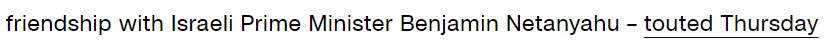

In [ ]:
loc = text.find("netanyahu credited netanyahu")
text[loc-30:loc+60]

'truce was due to take effect, netanyahu credited netanyahu administration\'s own "quiet and'

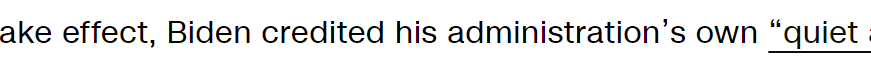

In [ ]:
# tsc = TargetSentimentClassifier()
# tsc.infer_from_text("i hate trump", "trump")

# In-article normalization

In [ ]:
cnn = pd.read_csv('../data/output_data/netanyahu_cnn_news_sentiment_not_norm.csv')
fox = pd.read_csv('../data/output_data/netanyahu_fox_news_sentiment_not_norm.csv')


In [ ]:
worst_precentile = cnn.compound_s.quantile(0.1)
best_precentile = cnn.compound_s.quantile(0.9)
print("worst_precentile (10%): ", worst_precentile, ". best_precentile (10%): ", best_precentile)

best_precentile = cnn.compound_s.quantile(0.95)
print("best_precentile (5%): ", best_precentile)

cnn[cnn.compound_s < worst_precentile].loc[:, ('title', 'compound_s')].values

worst_precentile (10%):  -0.9999355623692286 . best_precentile (10%):  0.5525246255121826
best_precentile (5%):  0.9353988630391642


array([["Opinion: Mitt Romney's moments of truth", -1.0],
       ['Israel targets Gaza with airstrikes after intercepting rocket attack',
        -1.0],
       ['Jacinda Ardern, like George Washington, knew when to quit',
        -0.9999956871917902],
       ['Biden tries to ease worries over US commitment to the Middle East in meetings with key leaders',
        -0.9999979156019558],
       ['Saudi Arabia opens airspace to Israeli flights',
        -0.9999979156019558],
       ['Israeli and Palestinian leaders speak by phone for the first time in years',
        -1.0],
       ['5 things to know for June 21: Gas prices, Ukraine, January 6, Israel, Covid-19',
        -0.9999922828773666],
       ['Israel and the West Bank are on edge again. Here are five things you need to know',
        -0.9999999974859916],
       ['Israeli officials deny report that police are using cellphone spying software on citizens without court approval',
        -0.999999999999998],
       ['Israel doubles dow

In [ ]:
cnn[cnn.compound_s > best_precentile].loc[:, ('title', 'compound_s')].values

array([['11 Palestinians killed during Israeli raid targeting militants in West Bank',
        0.9985939046633222],
       ["Opinion: What Europe makes of America's election result",
        0.9994010644617802],
       ['July 9, 2022 Shinzo Abe assassination news', 0.9999999602501988],
       ['July 8, 2022 Shinzo Abe shot dead in Nara, Japan',
        0.9999999602501988],
       ['Israel announces plan to double Golan Heights population, drawing condemnation from Syria',
        0.9993514270751204]], dtype=object)

### only one occurence
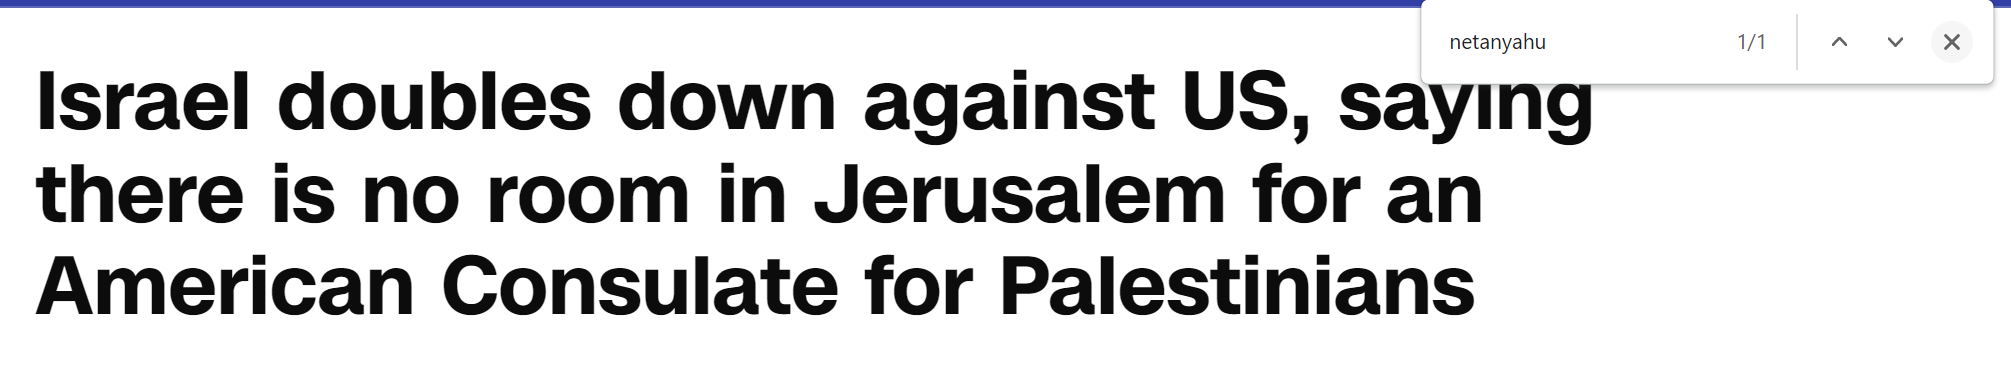

### colors the entire article as -1.0 negative (worst possible)
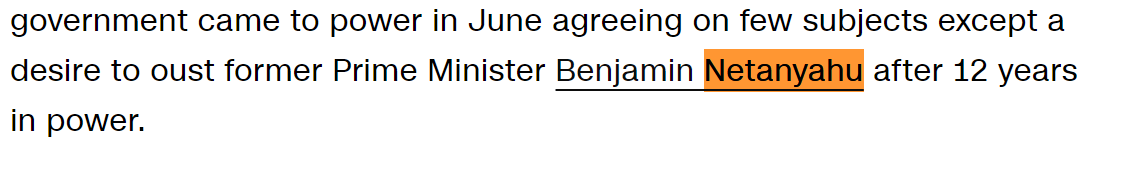

### low occurences penalty
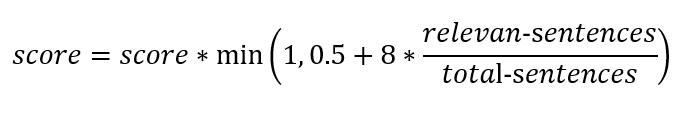

In [ ]:
cnn = pd.read_csv('../data/output_data/netanyahu_cnn_news_sentiment.csv')
fox = pd.read_csv('../data/output_data/netanyahu_fox_news_sentiment.csv')


In [ ]:
worst_precentile = cnn.compound_s.quantile(0.1)
best_precentile = cnn.compound_s.quantile(0.9)
print("worst_precentile (10%): ", worst_precentile, ". best_precentile (10%): ", best_precentile)

best_precentile = cnn.compound_s.quantile(0.95)
print("best_precentile (5%): ", best_precentile)

cnn[cnn.compound_s < worst_precentile].loc[:, ('title', 'compound_s')].values

worst_precentile (10%):  -0.8133121959478349 . best_precentile (10%):  0.5290328383681612
best_precentile (5%):  0.6911645036729865


array([['Israel targets Gaza with airstrikes after intercepting rocket attack',
        -1.0],
       ['A major oil exporter is hosting a UN climate summit. Opinions are divided',
        -0.8999349635766452],
       ['More than 80,000 people turn out for Tel Aviv protest against Netanyahu government',
        -0.9540841074848612],
       ['The world leaders who refuse to leave the stage',
        -0.9444444444444444],
       ["Israel's Prime Minister makes rare allusion to country's nuclear weapons arsenal",
        -0.9999999990541312],
       ['Saudi Arabia opens airspace to Israeli flights',
        -0.9444424758462916],
       ['Israeli and Palestinian leaders speak by phone for the first time in years',
        -1.0],
       ['A leader for all Israelis? Yair Lapid takes over as caretaker prime minister',
        -0.8917801697616614],
       ['Netanyahu negotiating possible corruption case plea deal to safeguard political career, sources say',
        -0.8638911902475801],
       

### Now it's way more clear
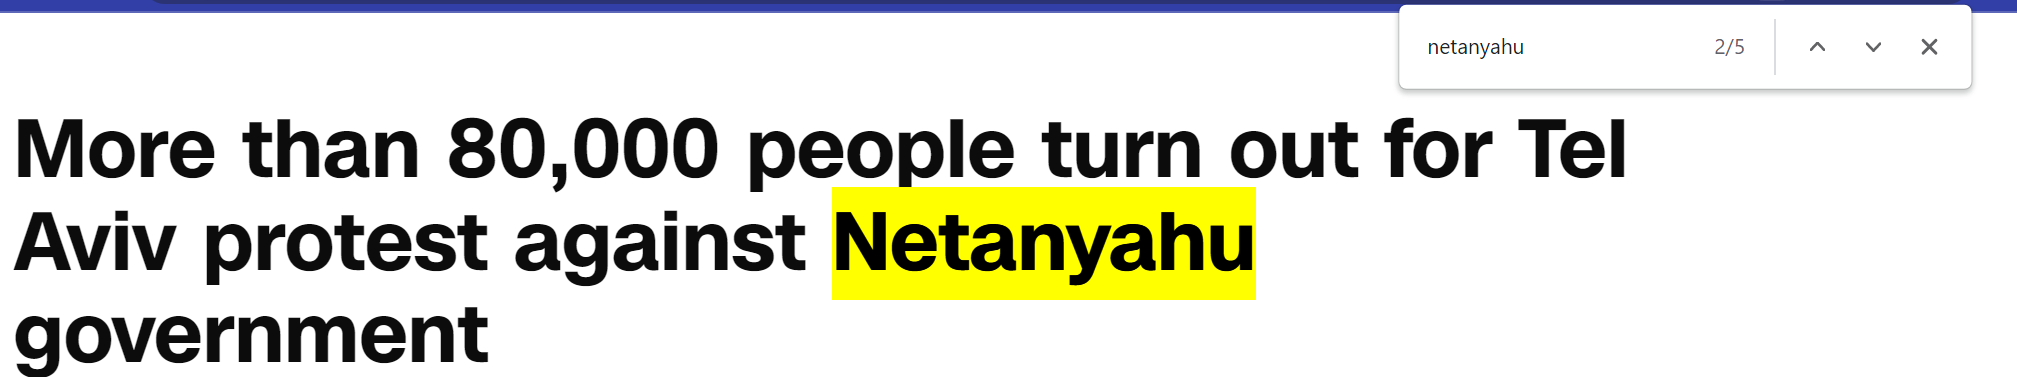

...

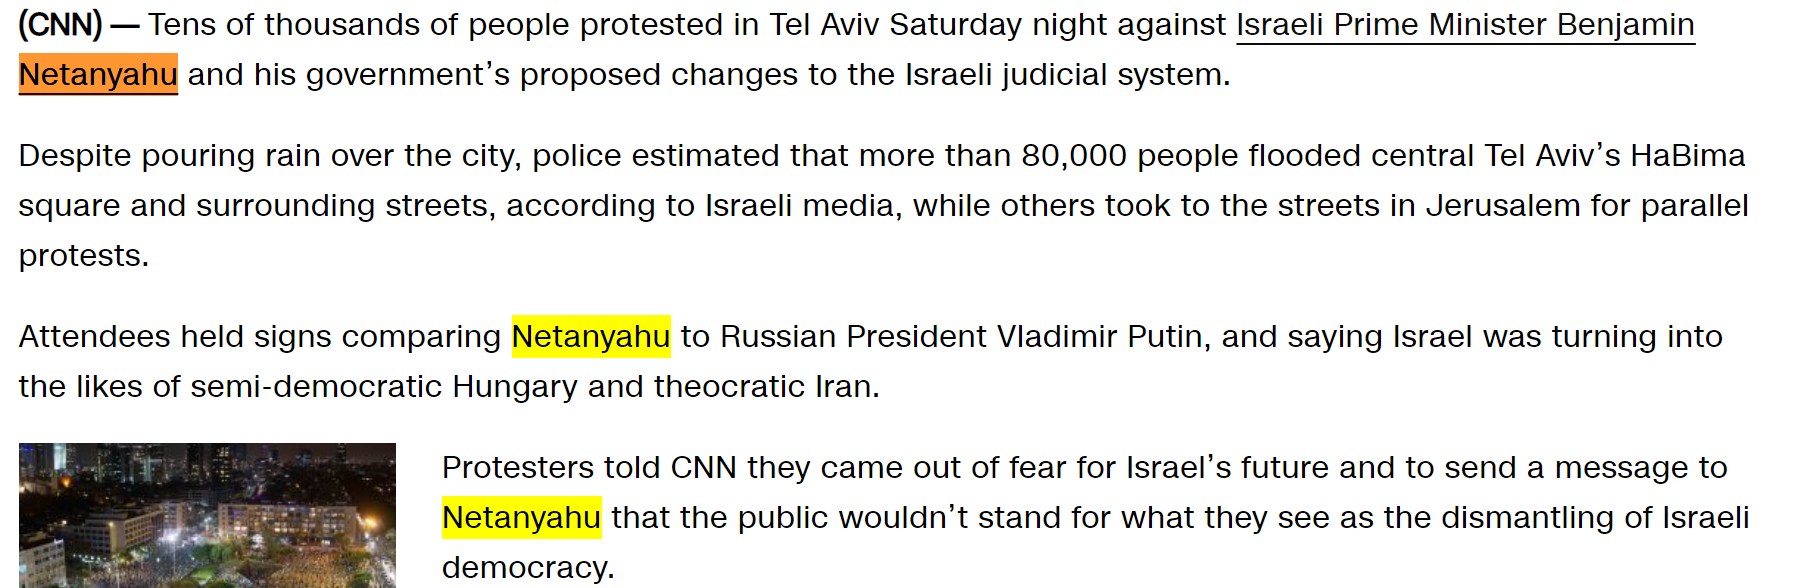

# Models

## "Industry Standart" Model results

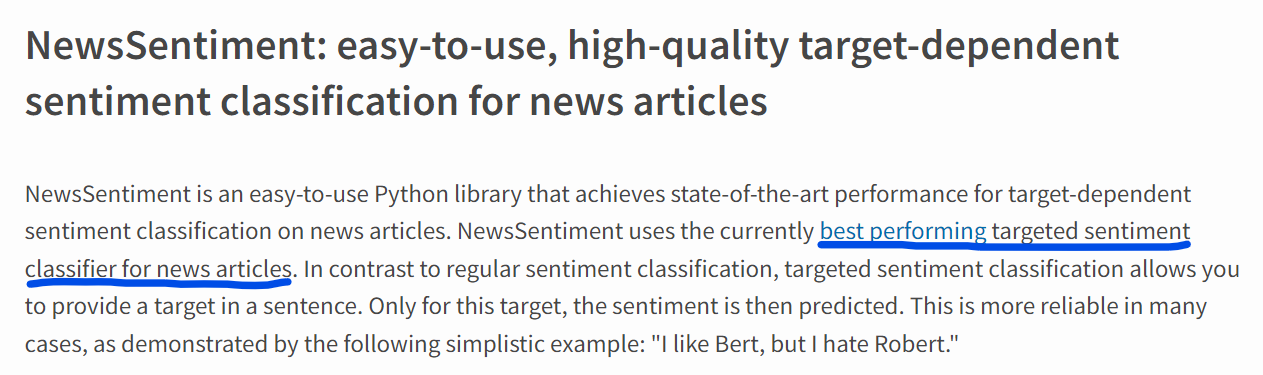

see [github repo](https://github.com/fhamborg/NewsMTSC) or [Hugging face page](https://huggingface.co/datasets/fhamborg/news_sentiment_newsmtsc)
  
and.. it's as easy as  
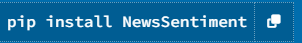

## 100 Netanyahu articles  

In [ ]:
def add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation):
    axes.text(0.02, 0.95, f'Correlation: {round(correlation,4)}',
                           fontdict={'size': 15, 'color':cur_color}, transform=axes.transAxes)
                
    axes.text(0.02, 0.92, f'Mean {vendor2}: {round(mean1,4)},',
                fontdict={'size': 10, 'color':dis_color}, transform=axes.transAxes)
    axes.text(0.02, 0.89, f'Mean {vendor1}: {round(mean2,4)}',
                fontdict={'size': 10, 'color':dis_color}, transform=axes.transAxes)
    return axes

### raw data

In [17]:
def plot(df:pd.DataFrame, vendor, color='#4287f5'):
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by=['date'])
    axes = df.plot(x='date', y='compound_s', kind='line', title=f'{vendor} News Sentiment', figsize=(17,8), color=color)


def joined_plot(df1:pd.DataFrame, df2:pd.DataFrame, vendor1, vendor2, color1='#4287f5', color2='#f56342'):  
    df1.date = pd.to_datetime(df1.date)
    df2.date = pd.to_datetime(df2.date)
    df1 = df1.sort_values(by=['date']).rename(columns={'compound_s': vendor1})
    df2 = df2.sort_values(by=['date']).rename(columns={'compound_s': vendor2})
    mean1 = df1[vendor1].mean()
    mean2 = df2[vendor2].mean()
    correlation = df1[vendor1].corr(df2[vendor2])
    axes = df1.plot(x='date', y=vendor1, kind='line', title=f'{vendor1} and {vendor2} News Sentiment', color=color1 , figsize=(17,8))
    add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)
    df2.plot(x='date', y=vendor2, kind='line', ax=axes, color=color2)
    df3 = pd.DataFrame({'date': df1.date, 'baseline': [0.0]*len(df1)}).plot(x='date', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')

plot(cnn, 'CNN')
plot(fox, 'Fox', color='#f56342')
# joined_plot(cnn, fox, 'CNN', 'Fox')

NameError: name 'cnn' is not defined

### Median aggrigation

In [21]:
def add_week_month(df:pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str) 
    df['month'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str) 
    return df

cnn = add_week_month(cnn)
fox = add_week_month(fox)


/tmp/ipykernel_9604/1222786786.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str)
/tmp/ipykernel_9604/1222786786.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str)


/tmp/ipykernel_9604/1589463902.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
/tmp/ipykernel_9604/1589463902.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
/tmp/ipykernel_9604/1589463902.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.gro

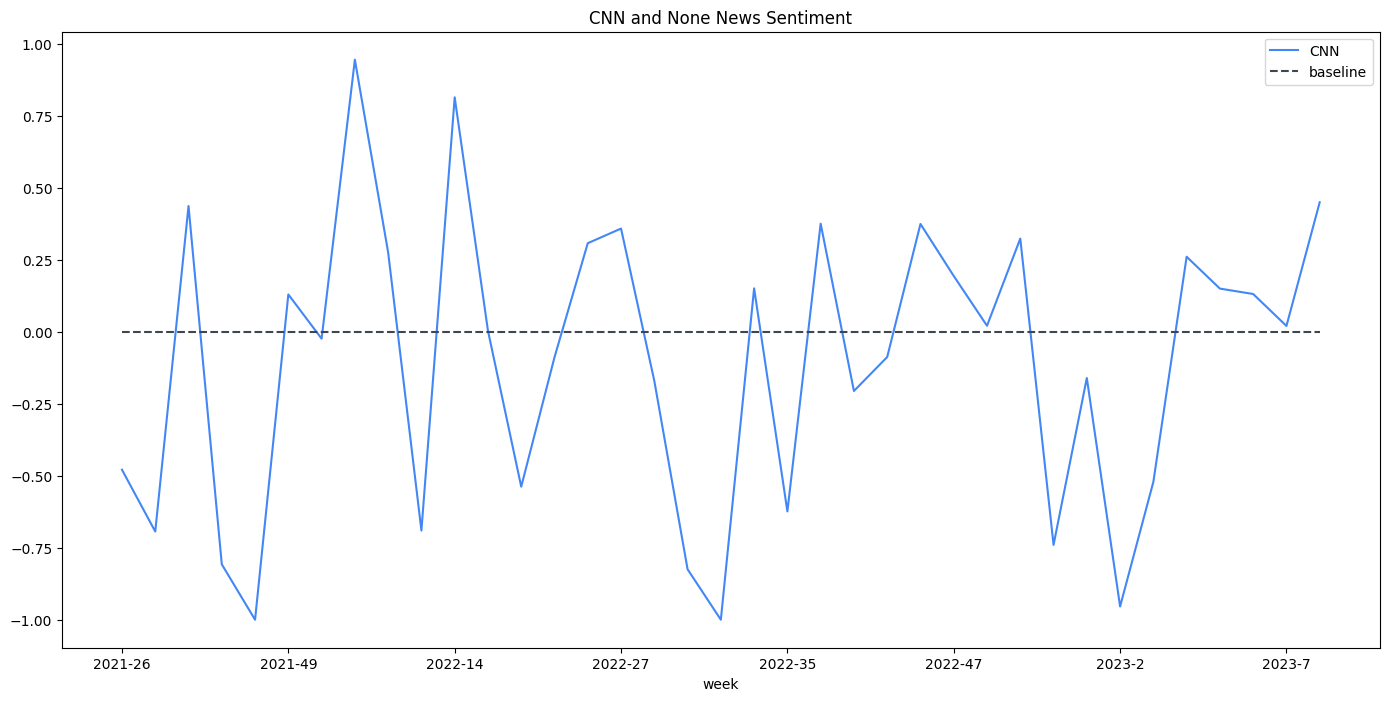

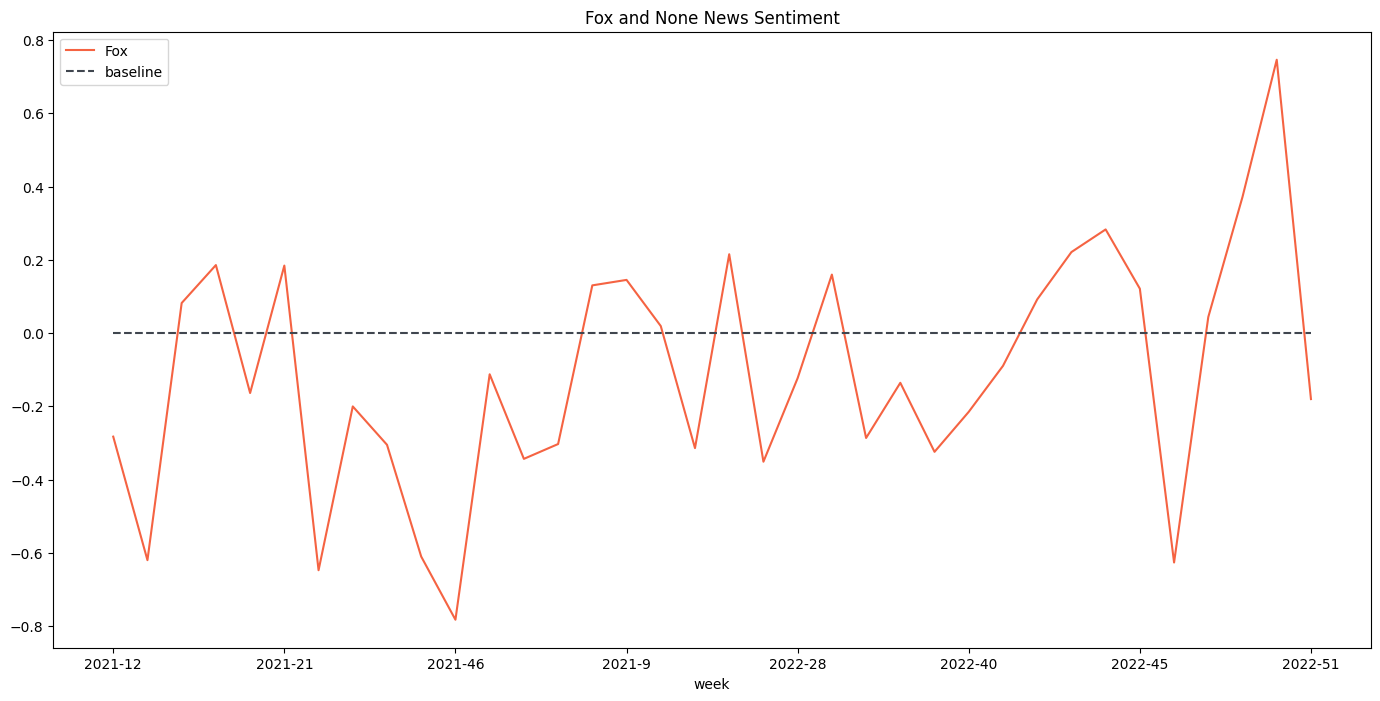

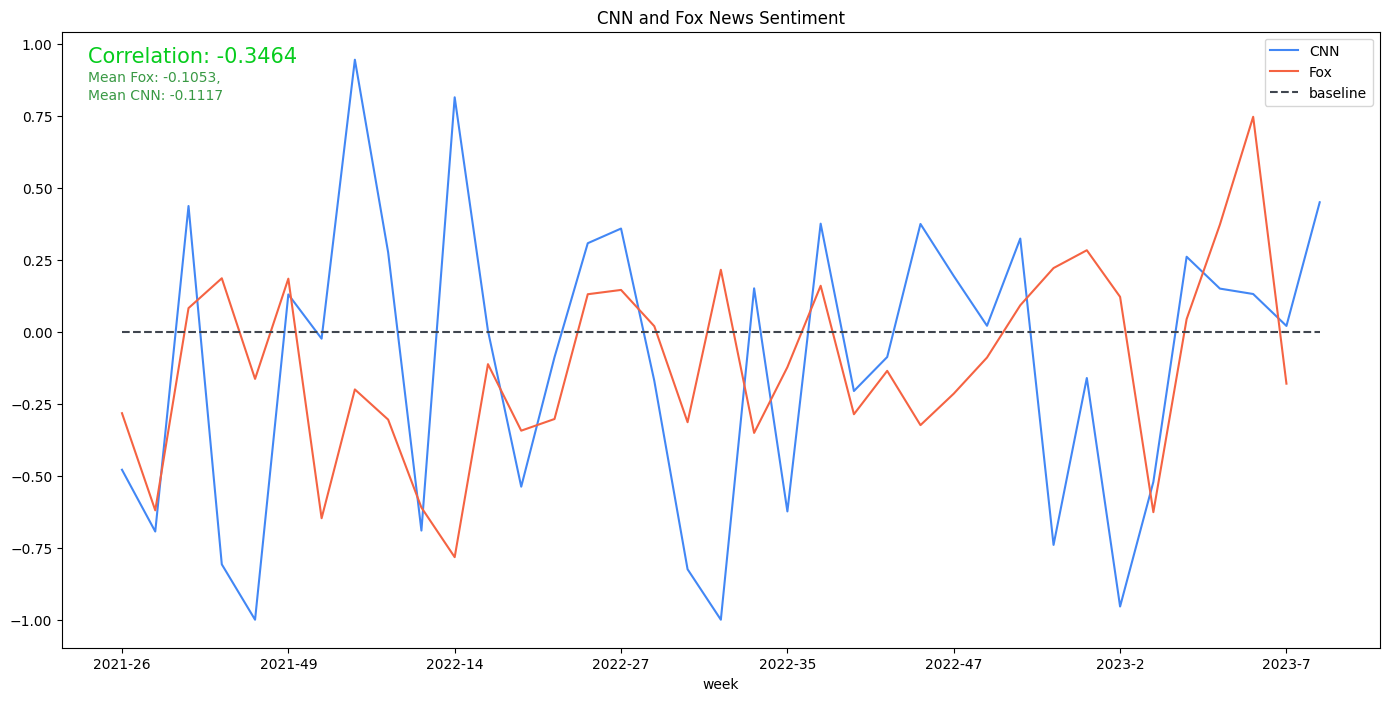

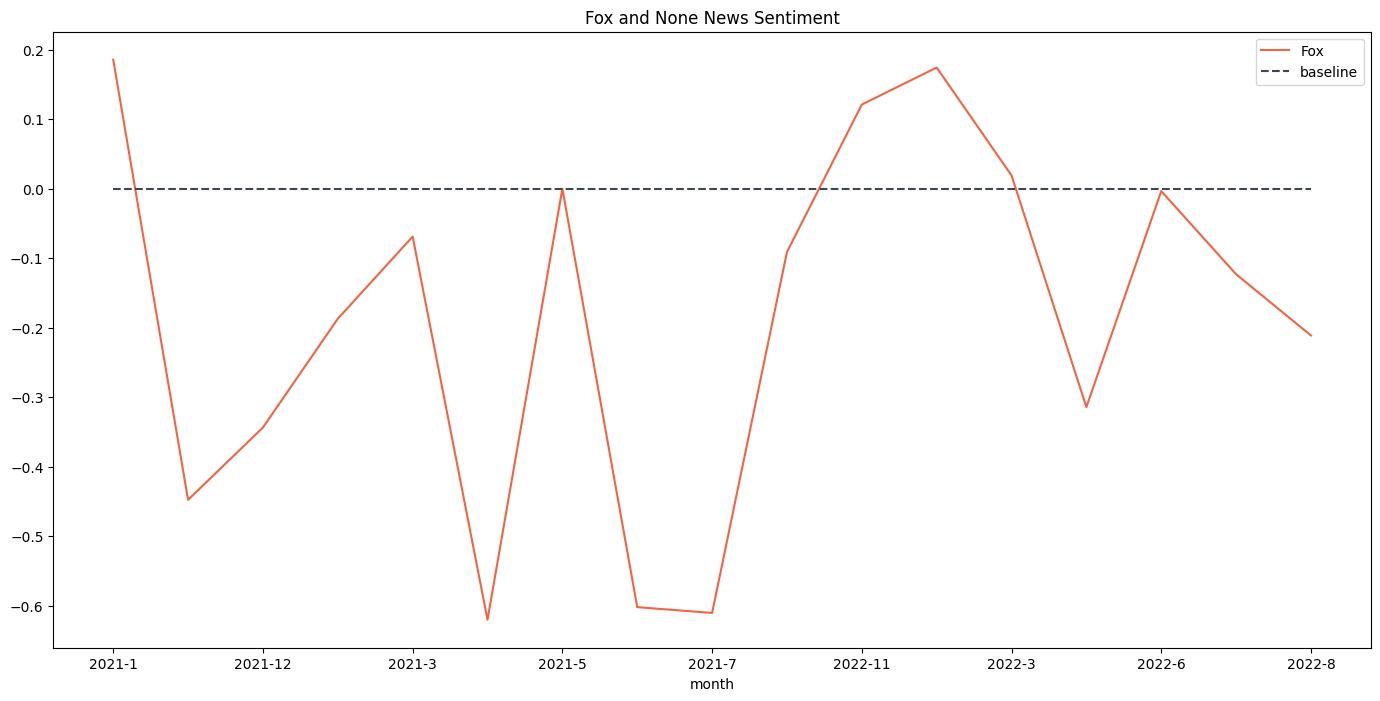

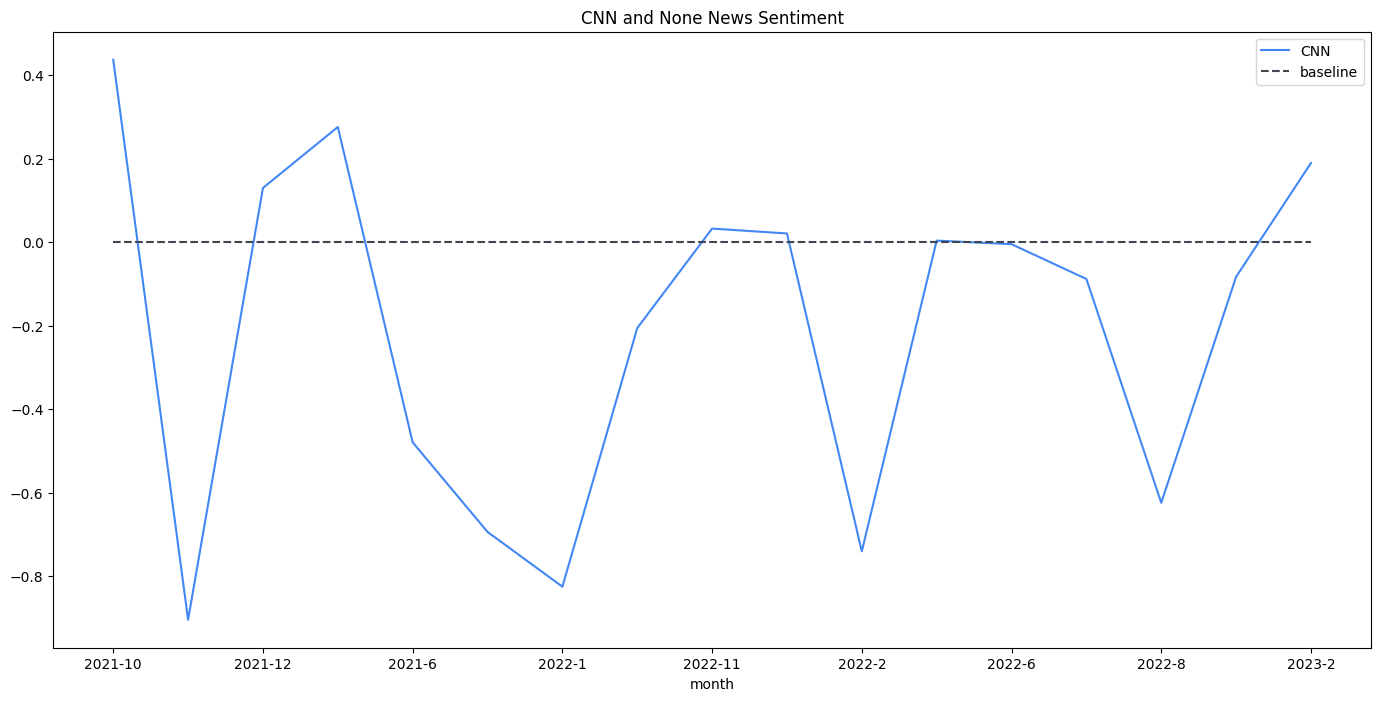

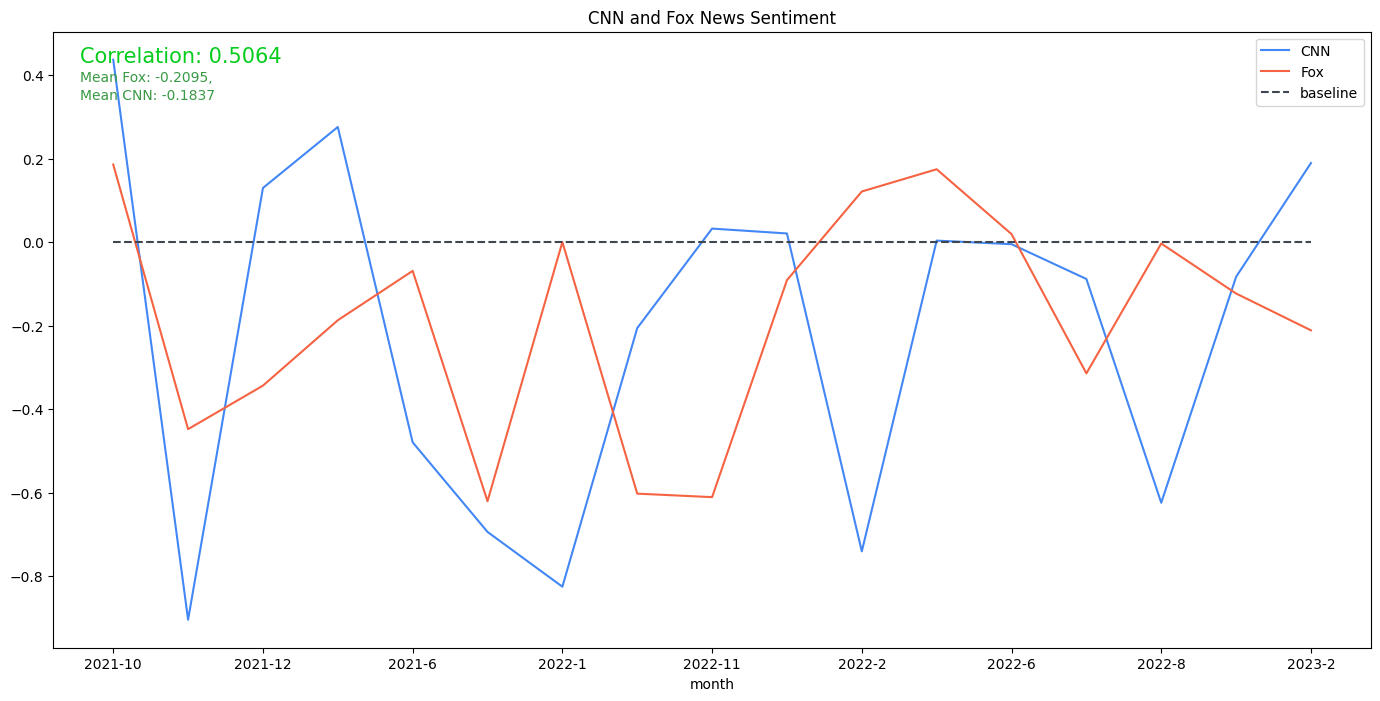

In [22]:
def monthly_avg_plot(df1:pd.DataFrame, vendor1, color='#4287f5', df2:pd.DataFrame = None, vendor2=None, color2='#f56342'):
            
            df1['date'] = pd.to_datetime(df1['date'])
            df1 = df1.sort_values(by=['month'], ascending=True)
            df1 = df1.groupby('month').median().rename(columns={'compound_s': vendor1})
            axes = df1.plot(y=vendor1, kind='line',
                             title=f'{vendor1} and {vendor2} News Sentiment', color=color , figsize=(17,8))
            if (df2 is not None):
                df2['date'] = pd.to_datetime(df2['date'])
                df2 = df2.sort_values(by=['month'], ascending=True)
                df2 = df2.groupby('month').median().rename(columns={'compound_s': vendor2})
                correlation = df2[vendor2].corr(df1[vendor1])
                mean1 = df1[vendor1].mean()
                mean2 = df2[vendor2].mean()

                df2.plot(y=vendor2, kind='line', ax=axes, color=color2)
                add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)

            pd.DataFrame({'month': df1.index, 'baseline': [0.0]*len(df1)}).plot(
                    x='month', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')

def weekly_avg_plot(df1:pd.DataFrame, vendor1, color='#4287f5', df2:pd.DataFrame = None, vendor2=None, color2='#f56342'):       
                df1['date'] = pd.to_datetime(df1['date'])
                df1 = df1.sort_values(by=['week'], ascending=True)
                df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
                axes = df1.plot(y=vendor1, kind='line', title=f'{vendor1} and {vendor2} News Sentiment', color=color , figsize=(17,8))

                if (df2 is not None):
                    df2['date'] = pd.to_datetime(df2['date'])
                    df2 = df2.sort_values(by=['week'], ascending=True)
                    df2 = df2.groupby('week').median().rename(columns={'compound_s': vendor2})
                    correlation = df2[vendor2].corr(df1[vendor1])
                    mean1 = df1[vendor1].mean()
                    mean2 = df2[vendor2].mean()
                    add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)
    
                    df2.plot(y=vendor2, kind='line', ax=axes, color=color2)
                pd.DataFrame({'week': df1.index, 'baseline': [0.0]*len(df1)}).plot(x='week', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')
    


weekly_avg_plot(cnn, 'CNN')
weekly_avg_plot(fox, 'Fox', color='#f56342')
weekly_avg_plot(cnn, 'CNN', df2=fox, vendor2='Fox', color2='#f56342')
monthly_avg_plot(fox, 'Fox', color='#f56342')
monthly_avg_plot(cnn, 'CNN')
monthly_avg_plot(cnn, 'CNN', df2=fox, vendor2='Fox', color2='#f56342')



## 3000 trump articles


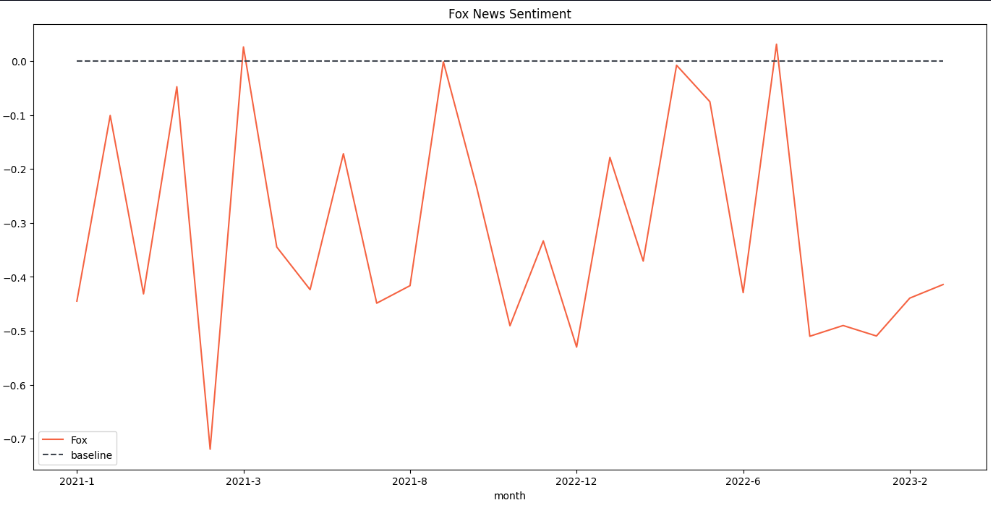

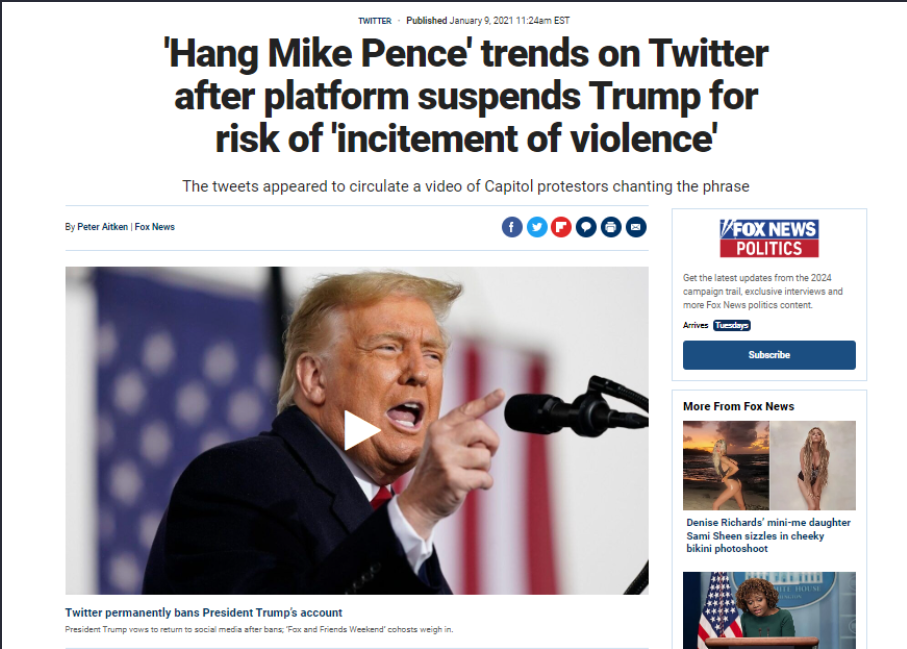

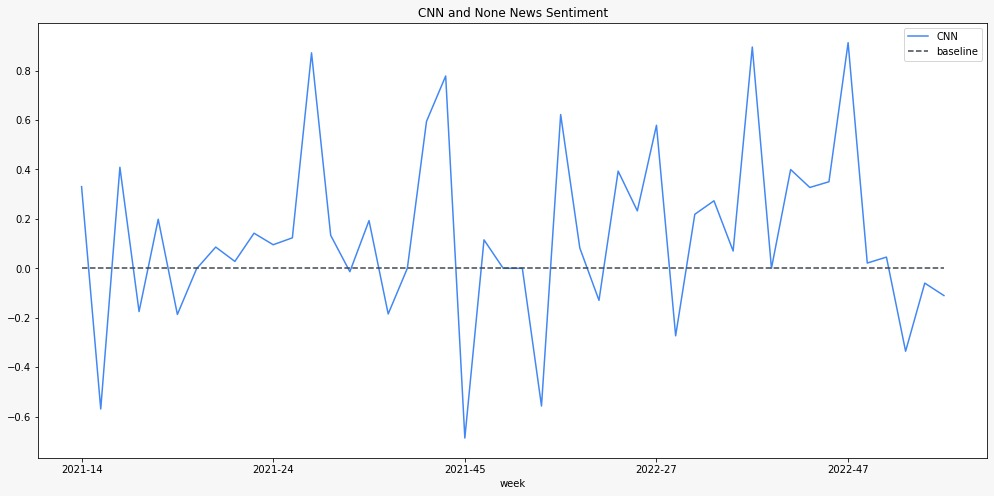

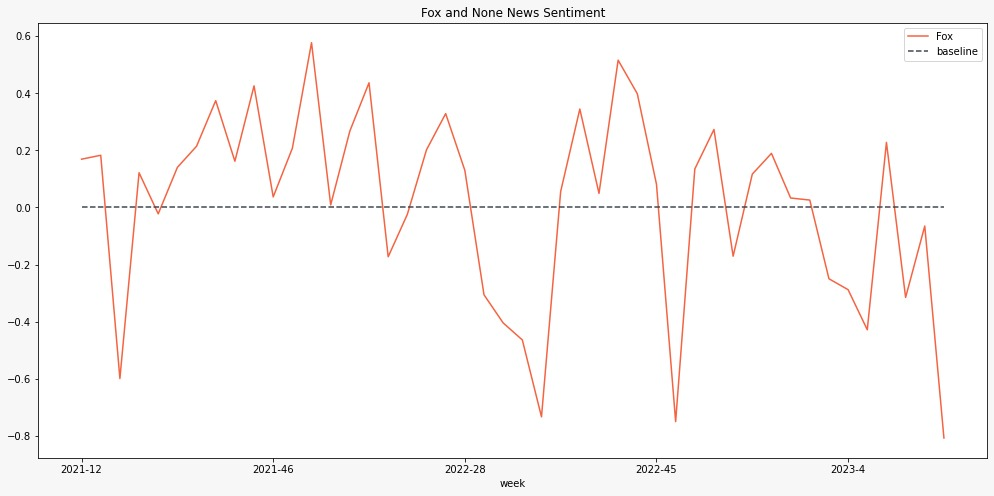

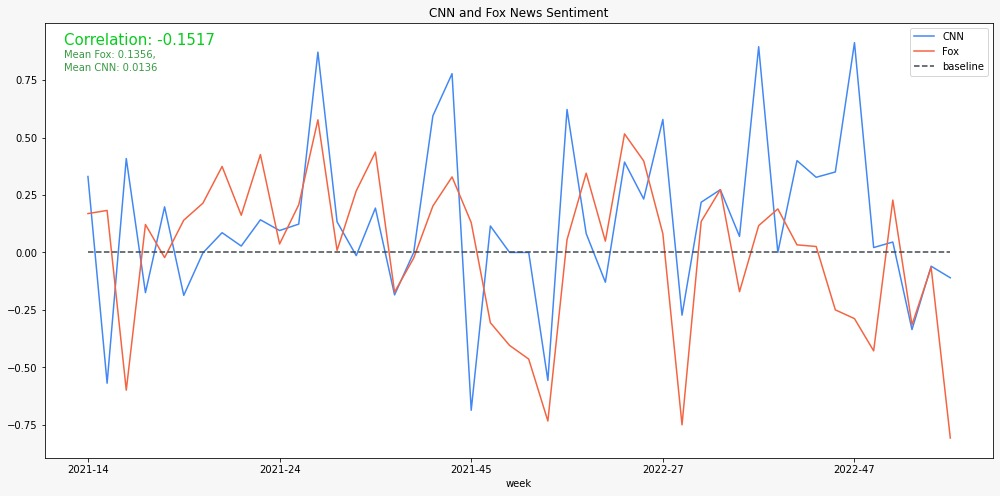